## Load Packages

In [9]:
using JuMP;
using HiGHS;
using Plots;
using ParametricOptInterface;
const POI = ParametricOptInterface;

# Newsvendor Problem

Every morning, the newsboy goes to the editor of the newspaper and buys a quantity of $x$ of newspapers at a cost of $c$ per unit. This $x$ amount is limited upwards by a $u$ value, as the newsboy has finite purchasing power. The decision is made under uncertainty since the demand  $d$  newspapers of the day is unknown. The number of $y$ newspapers is sold at a price of $q$ per unit. The newsboy also has an agreement with the newspaper editor: the number of unsold newspapers $w$ can be returned to the editor, who pays a $r$ price for him.

Consider the two-stage formulation:

$$\min_{0 \leq x \leq u} cx + \mathbb{E}_d[Q(x,d)]$$

where, 

$$Q(x,d) = \min_{y, z} \left\{ -qy -rz | y \leq d; y + z \leq x; y, z \geq 0 \right\}$$ 

Let $c=10$, $r=5$, $q=25$ e $u=150$. Also, assume that the demand follows a discrete probability distribution over the range $[60,150]$.

## 1) Compute and plot the function 
$$\mathcal{Q}(x)=E[Q(x,\tilde{d})] for  x\in\{60,70,\ldots,150\}.$$




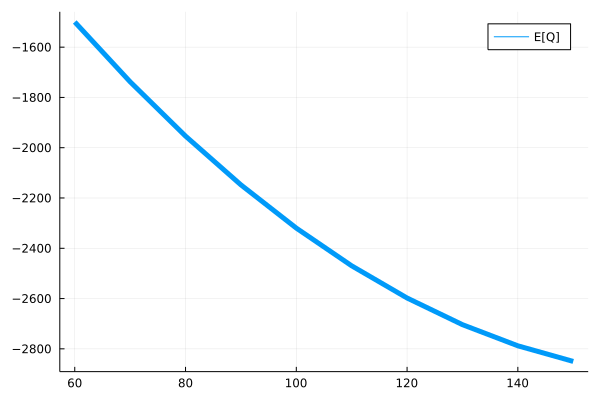

In [10]:
Q(X,D) = -25*min(D,X) - 5*max(X-D,0);
D = 60:1:150;
X = 60:10:150;
Q_x = zeros(length(X));

for i in eachindex(X), j in eachindex(D)
    Q_x[i] += Q(X[i],D[j])/length(D)
end
plt = plot(X, Q_x; label="E[Q]", lw = 5)

## 2) Develop a Benders decomposition algorithm for the newsvendor problem described above. In the same plot of item 1, plot the piecewise linear approximation for each iteration of the method.

In [11]:
struct NewsboyData
    u::Float64
    c::Float64
    q::Float64
    r::Float64
    d::Vector{Float64}
    p::Vector{Float64}
end

function get_newsboy_data(data::NewsboyData)
    u = data.u
    c = data.c
    q = data.q
    r = data.r
    d = data.d
    p = data.p
    return u, c, q, r, d, p
end

get_newsboy_data (generic function with 1 method)

In [12]:
function create_newsboy_main(data::NewsboyData)
    
    u, c, q, r, d, p = get_newsboy_data(data)
    S = length(d)
    
    main = Model(HiGHS.Optimizer)
    MOI.set(main, JuMP.MOI.Silent(), true)
    @variable(main, 0<=x<=u)
    @variable(main, -7000 <= theta)

    @objective(main, Min,c*x + theta)

    return main
end

function solve_newsboy_main(main::Model)
    
    optimize!(main)
    
    obj = objective_value(main)
    x = value(main[:x])

    return obj, x
end

function create_newsboy_subproblem(data::NewsboyData)
    
    u, c, q, r, d, p = get_newsboy_data(data)
    S = length(d)
    
    subproblem = Model(() -> ParametricOptInterface.Optimizer(HiGHS.Optimizer()))
    MOI.set(subproblem, JuMP.MOI.Silent(), true)
    @variable(subproblem, x in ParametricOptInterface.Parameter(0))
    @variable(subproblem, x_aux)
    @variable(subproblem, 0<=y[s=1:S]<=d[s])
    @variable(subproblem, 0<=z[1:S])

    @constraint(subproblem,[s = 1:S], y[s] + z[s] <= x_aux)
    @constraint(subproblem,dual_fisher ,x == x_aux)

    @objective(subproblem, Min, - sum(q*y[s]*p[s]+r*z[s]*p[s] for s = 1:S))

    return subproblem
end

function solve_newsboy_subproblem(subproblem::Model, x::Float64)
    
    MOI.set(subproblem, POI.ParameterValue(), subproblem[:x], x)
    optimize!(subproblem)
    
    obj = objective_value(subproblem)
    pi = dual(subproblem[:dual_fisher])

    return obj, pi
end

function update_main!(main::Model, x::Float64, pi::Float64, obj_sub::Float64)
    
    @constraint(main, main[:theta] >= obj_sub - pi * (main[:x] - x))
    nothing
end

function newsboy_bender(data::NewsboyData)
    main = create_newsboy_main(data)
    subproblem = create_newsboy_subproblem(data)
    obj_main, x = solve_newsboy_main(main)
    obj_sub, pi = solve_newsboy_subproblem(subproblem, x)
    LB = obj_main
    UB = obj_sub + data.c * x
    gap = UB - LB
    while gap >= 1e-6
        update_main!(main, x, pi, obj_sub)
        plot!(plt, X, obj_sub .+ pi*(x .- X))
        obj_main, x = solve_newsboy_main(main)
        obj_sub, pi = solve_newsboy_subproblem(subproblem, x)
        LB = obj_main
        UB = min(obj_sub + data.c * x , UB)
        @show gap = UB - LB
    end
    return main
end

newsboy_bender (generic function with 1 method)

In [13]:
data = NewsboyData(150,10,25,5,LinRange(60,150,91),ones(91)./91);
main = newsboy_bender(data);

gap = UB - LB = 899.9999999999977
gap = UB - LB = 217.49999999999955
gap = UB - LB = 55.60439560439545
gap = UB - LB = 3.0219780219783843
gap = UB - LB = 1.373626373626621
gap = UB - LB = 0.6868131868131968
gap = UB - LB = 0.21978021977975004
gap = UB - LB = 0.08241758241638308
gap = UB - LB = 0.0


In [14]:
value(main[:x])

128.00000000000207

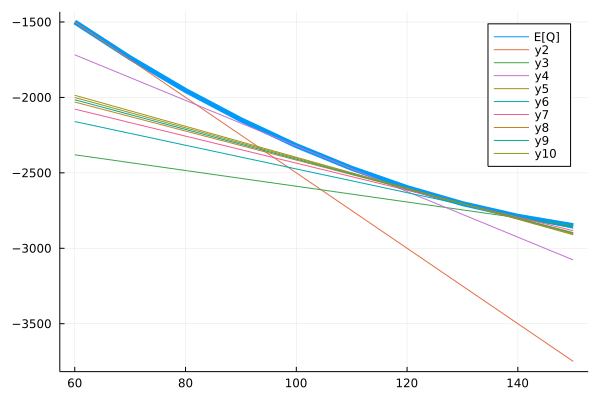

In [15]:
plt